In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

from train.metrics_f1 import calc_f1_score

In [2]:
path_train = r"../train/"

In [3]:
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
target_df = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()

In [4]:
target_df['month'] = pd.to_datetime(target_df['month'])
target_df.sample(5)

,wagnum,month,target_month,target_day
202293,8956,2022-12-01,0,0
123319,30766,2022-10-01,0,0
169551,23505,2022-11-01,0,0
112103,10429,2022-10-01,0,0
182765,8707,2022-12-01,0,0


In [5]:
target_df.target_month.mean()

0.0510220600138335

### Дислокация вагонов - сбор данных

In [6]:
dislok.columns

Index(['plan_date', 'wagnum', 'date_kap', 'date_dep', 'kod_vrab',
       'date_pl_rem', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob', 'isload', 'fr_id',
       'last_fr_id', 'distance'],
      dtype='object')

In [7]:
import gc
gc.collect()

0

In [8]:
dislok['days_to_pl_rem'] = (dislok['date_pl_rem'] - dislok['plan_date']).dt.days
dislok['another_road'] = dislok['id_road_dest'] != dislok['id_road_send']
dislok['last_rem_date'] = dislok[['date_kap', 'date_dep']].max(axis=1)
dislok['days_from_last_rem'] = (dislok['plan_date'] - dislok['last_rem_date']).dt.days

In [9]:
wagnum_subtables = {wagnum: table.sort_values(by='plan_date') for wagnum, table in tqdm(dislok.groupby('wagnum'))}

wagnum_subtables[0].dtypes

  0%|          | 0/33977 [00:00<?, ?it/s]

plan_date             datetime64[us]
wagnum                         Int64
date_kap              datetime64[us]
date_dep              datetime64[us]
kod_vrab                       Int64
date_pl_rem           datetime64[us]
id_road_disl                   Int64
st_id_dest                     Int64
id_road_dest                   Int64
st_id_send                     Int64
id_road_send                   Int64
ost_prob                       Int64
isload                         Int64
fr_id                          Int64
last_fr_id                     Int64
distance                       Int64
days_to_pl_rem                 int64
another_road                 boolean
last_rem_date         datetime64[us]
days_from_last_rem           float64
dtype: object

In [10]:
from itertools import product

intervals = [pd.DateOffset(days=10), pd.DateOffset(days=30), pd.DateOffset(days=90)]
functions = {"isload": ['mean']}
take_last_cols = ['date_kap', 'date_dep', 'kod_vrab', 'date_pl_rem', 'days_to_pl_rem', 'last_rem_date', 'days_from_last_rem', 'ost_prob']
rolling_cols = set()


for wagnum, table in tqdm(wagnum_subtables.items()):
    for interval in intervals:
        for col, func_list in functions.items():
            for func in func_list:
                table[f"{interval.days}d_{col}_{func}"] = getattr(table[col].rolling(interval.days), func)(engine='numba')
                rolling_cols.add(f"{interval.days}d_{col}_{func}")

  0%|          | 0/33977 [00:00<?, ?it/s]

In [14]:
target_df.sort_values(by=['month', 'wagnum'], inplace=True)

cols = take_last_cols + list(rolling_cols)

for wagnum in tqdm(wagnum_subtables.keys()):
    dates = target_df[target_df['wagnum'] == wagnum]['month']
    table = wagnum_subtables[wagnum]
    target_df.loc[target_df['wagnum'] == wagnum, cols] = table[table['plan_date'].isin(dates)][cols].values
    

  0%|          | 0/33977 [00:00<?, ?it/s]

ValueError: NumPy boolean array indexing assignment cannot assign 4 input values to the 6 output values where the mask is true

### Тип владения вагоном - обзор данных

In [79]:
wag_prob.columns

Index(['repdate', 'wagnum', 'ost_prob', 'manage_type', 'rod_id',
       'reestr_state', 'ownership_type', 'month'],
      dtype='object')

In [80]:
wag_prob.repdate.value_counts()

repdate
2022-11-20    33977
2022-11-19    33977
2022-11-18    33977
2022-11-17    33977
2022-11-16    33977
              ...  
2023-01-27    33709
2023-01-28    33709
2023-01-29    33709
2023-01-30    33708
2023-01-31    33708
Name: count, Length: 184, dtype: int64

In [84]:
wag_prob['manage_type'].value_counts()

manage_type
0    5838801
1     411056
Name: count, dtype: Int64

In [87]:
wag_prob['rod_id'].value_counts()

rod_id
1    3824207
0    2425650
Name: count, dtype: Int64

In [90]:
wag_prob['reestr_state'].value_counts()

reestr_state
1    6245239
2       4320
0        298
Name: count, dtype: Int64

In [92]:
wag_prob['ownership_type'].nunique()

1

### Характеристики вагонов - обзор данных

In [94]:
wag_param.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype'],
      dtype='object')

In [95]:
wag_param.model.value_counts()

model
12-132        11659
12-132-03      4034
11-286         3359
11-1807-01     2941
11-280         1731
11-2135-01     1711
11-276         1181
11-2163         950
12-1303-01      770
12-196-02       695
12-7023-02      686
11-1807         514
12-9788-01      475
12-783          421
11-9962         379
12-4102         320
12-1704-04      310
12-296-01       282
11-7038         225
12-600-05       193
12-9780         160
12-9766         138
12-9790         138
12-295          100
12-600-02        63
12-9085          63
11-1268          60
12-196-01        58
11-270           53
12-9046          49
12-1302          40
12-955           38
11-280-01        38
12-600-08        37
12-600-04        33
11-264           23
11-260           19
12-9745           7
12-532-02         6
12-9837           6
11-066-04         2
11-217            2
12-9850-02        1
12-1000           1
12-600-07         1
11-К001           1
11-066-08         1
12-753-03         1
Р-9494-01         1
11-259        

In [96]:
wag_param['ownertype'].value_counts()

ownertype
0    31354
1     2623
Name: count, dtype: Int64

<Axes: ylabel='Frequency'>

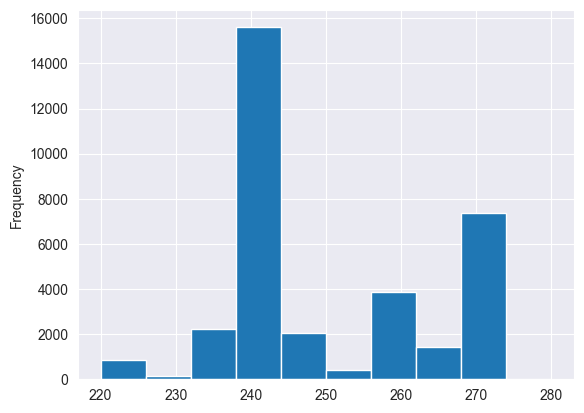

In [108]:
wag_param['tara'].plot.hist(bins=10, range=(220, 280))

<Axes: ylabel='Frequency'>

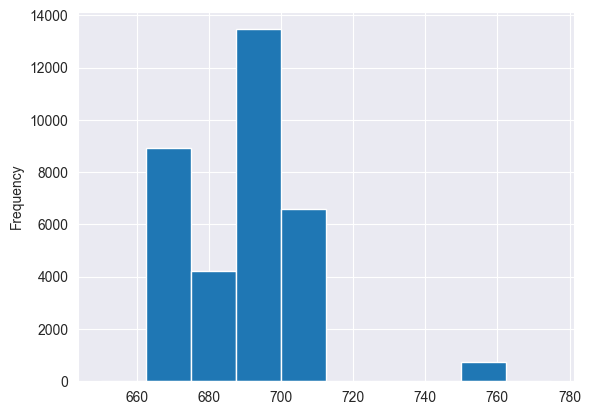

In [107]:
wag_param['gruz'].plot.hist(bins=10, range=(650, 775))

/home/flypew/Programming/MLvenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


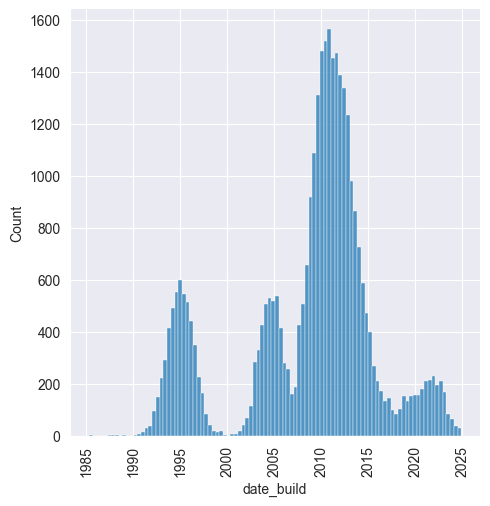

In [131]:
dates = wag_param['date_build']
sns.displot(dates, bins=100, kde=False)
plt.xticks(rotation=90)
plt.show()

/home/flypew/Programming/MLvenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


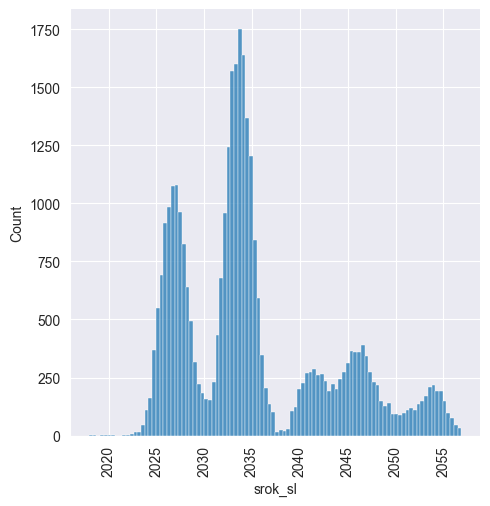

In [132]:
dates = wag_param['srok_sl']
sns.displot(dates, bins=100, kde=False)
plt.xticks(rotation=90)
plt.show()

<Axes: ylabel='Frequency'>

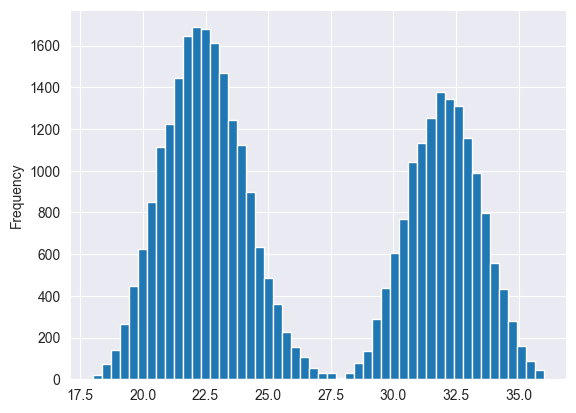

In [133]:
wag_param['expected_srok_sl_y'] = (wag_param['srok_sl'] - wag_param['date_build']).dt.days / 365
wag_param['expected_srok_sl_y'].plot.hist(bins=50, range=(18, 36))

In [134]:
wag_param['expected_srok_sl_y_b'] = wag_param['expected_srok_sl_y'].apply(lambda x: "short" if x <= 27.5 else "long")
wag_param['expected_srok_sl_y_b'].value_counts()

expected_srok_sl_y_b
short    19639
long     14338
Name: count, dtype: int64

In [137]:
# Discretize date_build into classes <2000, 2000-2007, 2008-2017, 2017+
# Use pd.cut, bins=[0, 2000, 2007, 2017, 2030]
wag_param['date_build_b'] = pd.cut(wag_param['date_build'].dt.year, bins=[0, 2000, 2007, 2017, 2030])
wag_param['date_build_b'].value_counts()

date_build_b
(2007, 2017]    20891
(0, 2000]        5340
(2000, 2007]     5242
(2017, 2030]     2504
Name: count, dtype: int64

In [140]:
wag_param['zavod_build'].value_counts()

zavod_build
0     15756
1      9453
17     2722
2      1334
6      1285
15      710
13      700
20      379
9       333
8       320
5       209
4       160
18      138
11      106
21       88
3        87
19       64
16       56
10       39
12       23
7         7
14        6
22        1
23        1
Name: count, dtype: Int64

In [141]:
wag_param['cnsi_probeg_dr'].value_counts()

cnsi_probeg_dr
110    30779
160     1494
320      950
350      753
250        1
Name: count, dtype: Int64

In [142]:
wag_param['cnsi_probeg_kr'].value_counts()

cnsi_probeg_kr
160    32236
320      950
500      754
0         37
Name: count, dtype: Int64

In [143]:
wag_param['kuzov'].value_counts()

kuzov
2     27403
22     4927
43     1645
1         2
Name: count, dtype: Int64

In [144]:
wag_param['norma_km'].value_counts()

norma_km
160000    31291
350000      753
0           749
110000      642
500000      490
210000       50
250000        1
320000        1
Name: count, dtype: Int64